# Classification


In [1]:
%load_ext lab_black

In [2]:
import gpjax
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax.random as jr
from jax.scipy.special import erf
from jax.experimental import optimizers
import tensorflow_probability.substrates.jax as tfp

key = jr.PRNGKey(123)
tfd = tfp.distributions

## Datasets

We'll simulate a binary dataset where our inputs $x$ are sampled according to $x_i \sim \mathcal{U}(-1., 1.)$ for $1 \leq i \leq 100$. Our corresponding outputs will be calculated according to
$$ y_i = 0.5*\operatorname{sign}(\cos(2*x + \epsilon_i) + 0.5, $$
where $\epsilon_i \sim \mathcal{N}(0, 0.01)$. Note, the multiplication and addition of 0.5 is simply to ensure that our outputs are in $\{0, 1\}$.

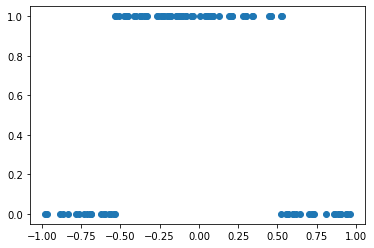

In [3]:
x = jnp.sort(jr.uniform(key, shape=(100, 1), minval=-1.0, maxval=1.0), axis=0)
y = 0.5 * jnp.sign(jnp.cos(3 * x + jr.normal(key, shape=x.shape) * 0.05)) + 0.5
xtest = jnp.linspace(-1.05, 1.05, 500).reshape(-1, 1)
plt.plot(x, y, "o")

We can now define our prior Gaussian process such that an RBF kernel has been selected for the purpose of exposition. However, an alternative kernel may be a better choice.

In [4]:
from gpjax.kernel import RBF
from gpjax.gps import Prior

kern = RBF()
prior = Prior(kernel=kern)

Now we can proceed to define our likelihood function. In this example, our observations are binary, so we will select a Bernoulli likelihood. Using this likelihood function, we can compute the posterior through the product of our likelihood and prior.

In [5]:
from gpjax.likelihoods import Bernoulli, Poisson, Gaussian

posterior = prior * Bernoulli()
print(type(posterior))

<class 'gpjax.gps.NonConjugatePosterior'>


In [6]:
from gpjax.parameters import initialise, complete
from gpjax.transforms import transform, SoftplusTransformation

hyperparams = {"lengthscale": jnp.array([1.0]), "variance": jnp.array([1.0])}
params = transform(complete(hyperparams, posterior, x.shape[0]), SoftplusTransformation)

With a posterior in place, we can estimate the maximum a posteriori using ObJax's optimisers. However, our Gaussian process is no longer conjugate, meaning that in addition to the kernel's hyperparameters, we are also tasked with learning the values of process' latent function.

In [7]:
from gpjax.mlls import marginal_ll

mll = marginal_ll(posterior, negative=True)

In [8]:
mll(params, x, y)

DeviceArray(161.20856981, dtype=float64)

In [9]:
opt_init, opt_update, get_params = optimizers.adam(step_size=0.01)
opt_state = opt_init(params)

In [10]:
def step(i, opt_state):
    p = get_params(opt_state)
    v, g = jax.value_and_grad(mll)(p, x, y)
    return opt_update(i, g, opt_state), v

In [11]:
nits = 1000
mlls = []

for i in range(nits):
    opt_state, mll_estimate = step(i, opt_state)
    mlls.append(-mll_estimate)

Let us now visualise our optimisation procedure by plotting the increasing marginal log-likelihood value.

Text(0.5, 0, 'Optimsation step number')

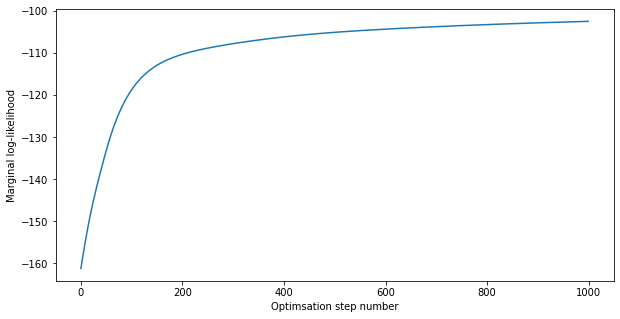

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(mlls)
ax.set_ylabel("Marginal log-likelihood")
ax.set_xlabel("Optimsation step number")

In [13]:
from gpjax.transforms import untransform

final_params = untransform(get_params(opt_state), SoftplusTransformation)

In [14]:
from gpjax.predict import mean, variance

mu = mean(posterior, final_params, xtest, x, y)
sigma = 1.96 * jnp.sqrt(variance(posterior, final_params, xtest, x, y))

With the first and centralised second moment computed, we can plot these with the original data overlayed to confirm that our process has done a good job of recovering the latent function.

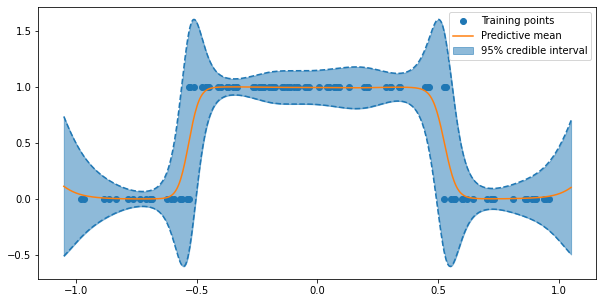

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, y, "o", label="Training points")
ax.plot(xtest, mu, label="Predictive mean", color="tab:orange")
ax.fill_between(
    xtest.ravel(),
    mu.squeeze() - sigma,
    mu.squeeze() + sigma,
    alpha=0.5,
    label="95% credible interval",
    color="tab:blue",
)
ax.plot(xtest, mu + sigma, color="tab:blue", linestyle="--")
ax.plot(xtest, mu - sigma, color="tab:blue", linestyle="--")
ax.legend(loc="best")
# plt.savefig("predictive_posterior.png")